In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

In [2]:
import cv2

In [3]:
if os.path.exists('dog.jpg'):
    print('dog.jpg exists')
else:
    !wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O dog.jpg

--2024-09-20 10:02:18--  https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg
Resolving segment-anything.com (segment-anything.com)... 18.161.6.30, 18.161.6.86, 18.161.6.35, ...
Connecting to segment-anything.com (segment-anything.com)|18.161.6.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 221810 (217K) [image/jpeg]
Saving to: ‘dog.jpg’

dog.jpg             100%[===================>] 216.61K  --.-KB/s    in 0.04s   

2024-09-20 10:02:19 (5.81 MB/s) - ‘dog.jpg’ saved [221810/221810]



In [4]:
# Read in a image from torchvision
img = torchvision.io.read_image("dog.jpg")
print(img.shape)

torch.Size([3, 1365, 2048])


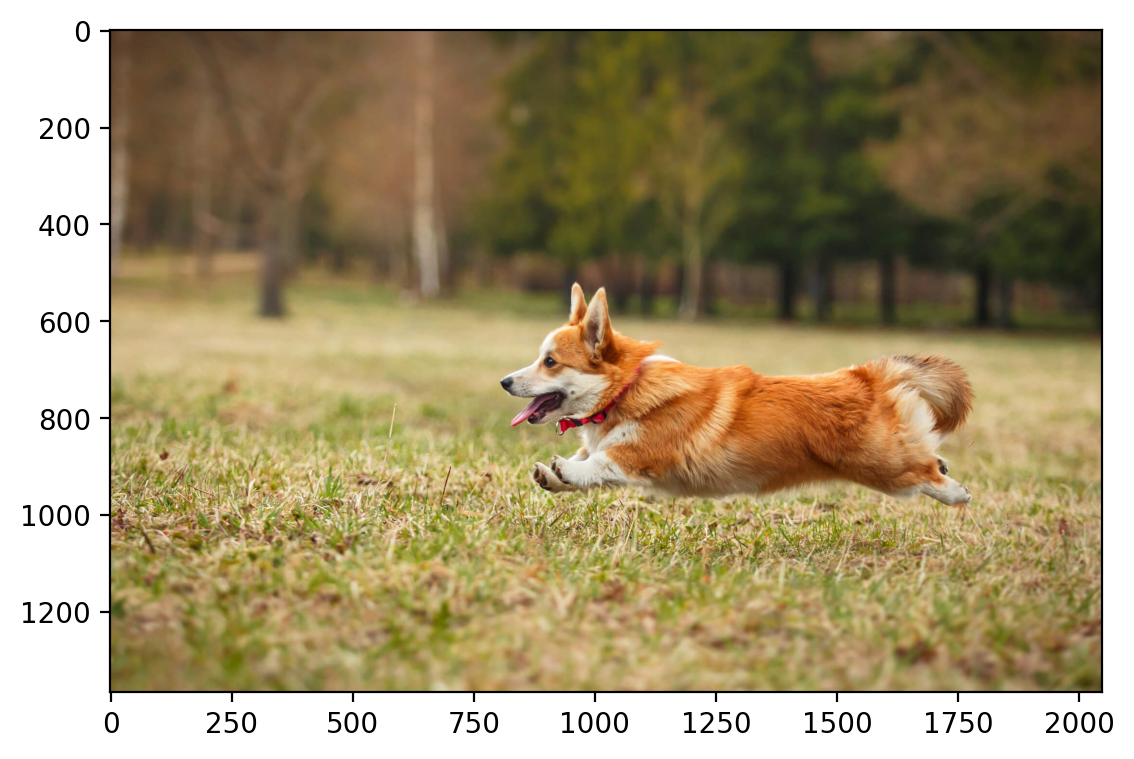

In [5]:
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())

In [6]:
img.type

<function Tensor.type>

In [7]:
from sklearn import preprocessing

scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))    ## Basically converts n elements in n rows with 1 column
scaler_img

MinMaxScaler()

In [8]:
img.type

<function Tensor.type>

In [9]:
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)

In [10]:
img_scaled = torch.tensor(img_scaled).to(device)

In [11]:
img_scaled = img_scaled.to(device)
img_scaled

tensor([[[0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         ...,
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3765, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3804, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3843, 0.3804, 0.3804]],

        [[0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         ...,
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3176, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3216, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3255, 0.3216, 0.3216]],

        [[0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.

In [12]:
img_scaled.shape

torch.Size([3, 1365, 2048])

In [13]:
crop = torchvision.transforms.functional.crop(img_scaled.cpu(), 500, 800, 400, 400)
crop.shape

torch.Size([3, 400, 400])

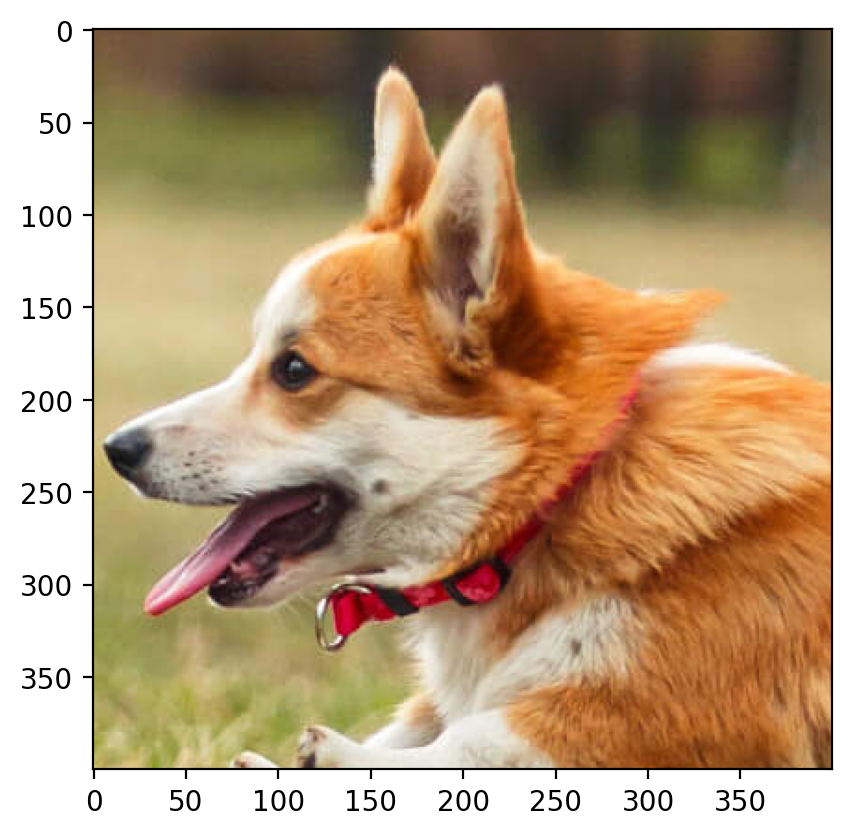

In [14]:
plt.imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())

In [15]:
crop = crop.to(device)

In [16]:
crop

tensor([[[0.4549, 0.4549, 0.4549,  ..., 0.3882, 0.3961, 0.4000],
         [0.4588, 0.4588, 0.4588,  ..., 0.3882, 0.3961, 0.4000],
         [0.4588, 0.4588, 0.4588,  ..., 0.3882, 0.3961, 0.4000],
         ...,
         [0.7961, 0.7373, 0.7176,  ..., 0.5216, 0.5569, 0.6118],
         [0.8471, 0.7843, 0.7451,  ..., 0.5216, 0.5569, 0.6039],
         [0.8784, 0.8196, 0.7686,  ..., 0.5059, 0.5373, 0.5804]],

        [[0.3333, 0.3333, 0.3333,  ..., 0.3216, 0.3294, 0.3333],
         [0.3373, 0.3373, 0.3373,  ..., 0.3216, 0.3294, 0.3333],
         [0.3373, 0.3373, 0.3373,  ..., 0.3216, 0.3294, 0.3333],
         ...,
         [0.7686, 0.7098, 0.6863,  ..., 0.3608, 0.4000, 0.4549],
         [0.8157, 0.7569, 0.7137,  ..., 0.3608, 0.3961, 0.4471],
         [0.8431, 0.7882, 0.7333,  ..., 0.3529, 0.3882, 0.4314]],

        [[0.2235, 0.2235, 0.2235,  ..., 0.2196, 0.2196, 0.2235],
         [0.2275, 0.2275, 0.2275,  ..., 0.2196, 0.2196, 0.2235],
         [0.2275, 0.2275, 0.2275,  ..., 0.2196, 0.2196, 0.

In [17]:
print(crop.shape)

torch.Size([3, 400, 400])


In [18]:

# Move the tensor to CPU before converting to NumPy
crop_np = crop.permute(1, 2, 0).cpu().numpy()  # From (3, 400, 400) to (400, 400, 3)

# Resize the image using OpenCV
resize_crop_np = cv2.resize(crop_np, (200, 200))  # Resizes to (200, 200, 3)

# Convert the NumPy array to float32 (or another compatible data type)
resize_crop_np = resize_crop_np.astype(np.float32)

# Convert back to a PyTorch tensor and rearrange dimensions, move back to the original device
resize_crop = torch.tensor(resize_crop_np).permute(2, 0, 1).to(device)  # From (200, 200, 3) back to (3, 200, 200)

# Print the updated shape
print(resize_crop.shape)


torch.Size([3, 200, 200])


In [19]:
crop.shape

torch.Size([3, 400, 400])

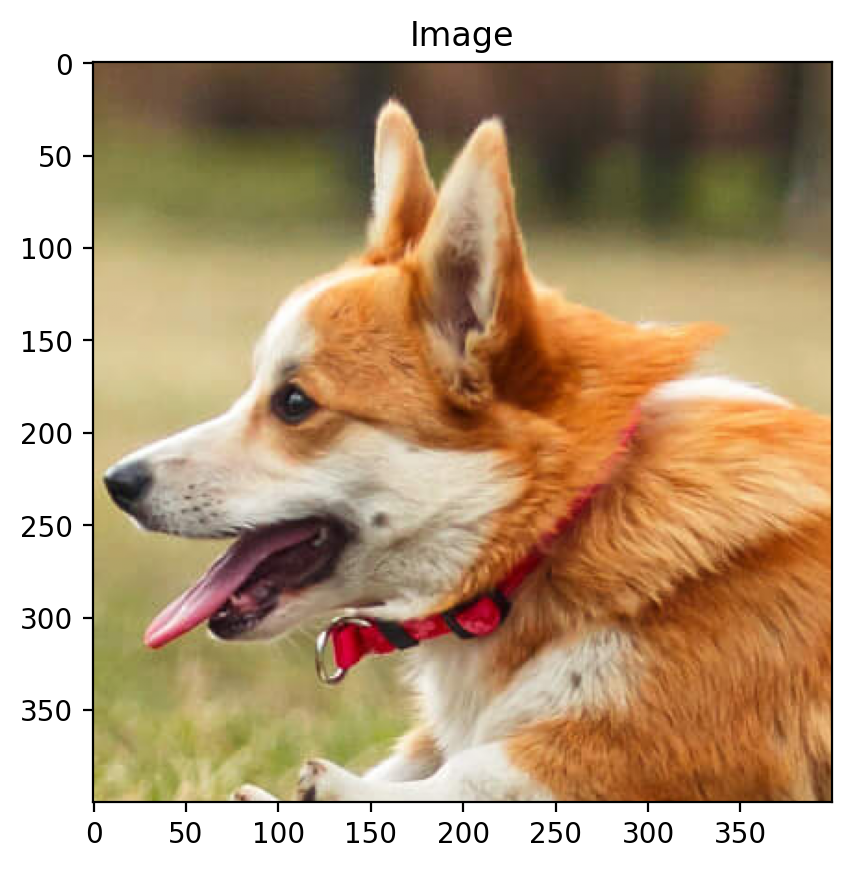

In [20]:
rcp = crop.cpu().permute(1, 2, 0).numpy()  # Convert back to [Height, Width, Channels] for plotting
plt.imshow(rcp)
plt.title("Image")
plt.show()

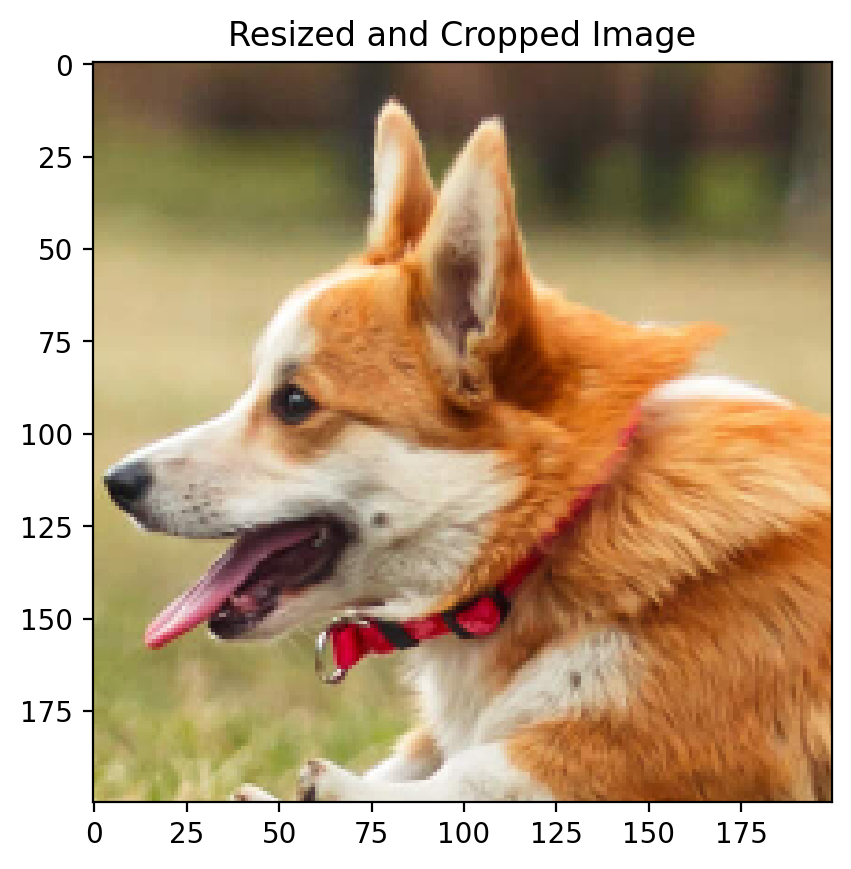

In [21]:

# Plot the resized image
resize_crop_np = resize_crop.cpu().permute(1, 2, 0).numpy()  # Convert back to [Height, Width, Channels] for plotting
plt.imshow(resize_crop_np)
plt.title("Resized and Cropped Image")
plt.show()

In [22]:
resize_crop = resize_crop.to(device)


In [23]:
def create_coordinate_map(img):
    """
    img: torch.Tensor of shape (num_channels, height, width)

    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """

    num_channels, height, width = img.shape

    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)

    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y

In [24]:
dog_400_X, dog_400_Y = create_coordinate_map(crop)

dog_400_X.shape, dog_400_Y.shape

(torch.Size([160000, 2]), torch.Size([160000, 3]))

In [25]:
dog_400_X

tensor([[  0.,   0.],
        [  0.,   1.],
        [  0.,   2.],
        ...,
        [399., 397.],
        [399., 398.],
        [399., 399.]], device='cuda:0')

In [26]:
dog_400_Y

tensor([[0.4549, 0.3333, 0.2235],
        [0.4549, 0.3333, 0.2235],
        [0.4549, 0.3333, 0.2235],
        ...,
        [0.5059, 0.3529, 0.1843],
        [0.5373, 0.3882, 0.2118],
        [0.5804, 0.4314, 0.2471]], device='cuda:0')

In [27]:
# MinMaxScaler from -1 to 1
scaler_400_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(dog_400_X.cpu())

# Scale the X coordinates
dog_400_X_scaled = scaler_400_X.transform(dog_400_X.cpu())

# Move the scaled X coordinates to the GPU
dog_400_X_scaled = torch.tensor(dog_400_X_scaled).to(device)

# Set to dtype float32
dog_400_X_scaled = dog_400_X_scaled.float()

In [28]:
dog_400_X_scaled

tensor([[-1.0000, -1.0000],
        [-1.0000, -0.9950],
        [-1.0000, -0.9900],
        ...,
        [ 1.0000,  0.9900],
        [ 1.0000,  0.9950],
        [ 1.0000,  1.0000]], device='cuda:0')

In [29]:
# sigma

In [30]:
dog_400_X_scaled.shape

torch.Size([160000, 2])

In [31]:
dog_400_Y.shape

torch.Size([160000, 3])

In [32]:
# dog_X_scaled.shape

In [33]:
# create RFF features
def create_rff_features(X, num_features, sigma):
    from sklearn.kernel_approximation import RBFSampler
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2), random_state = 42)
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device)

In [34]:
sigma1 = 0.005

In [35]:
dog_400_X.shape

torch.Size([160000, 2])

In [36]:
dog_400_Y.shape

torch.Size([160000, 3])

In [37]:
X_400_rff = create_rff_features(dog_400_X_scaled, 9000, sigma1)

In [38]:
X_400_rff.shape

torch.Size([160000, 9000])

In [39]:
# def downsample_rff_features(rff_features, original_size, target_size):
#     """
#     Downsample RFF features to a smaller size (e.g., from 400x400 to 200x200).

#     rff_features: torch.Tensor of shape (original_size * original_size, num_features)
#     original_size: int, the original image size (e.g., 400)
#     target_size: int, the target image size (e.g., 200)

#     return: torch.Tensor of shape (target_size * target_size, num_features)
#     """
#     num_features = rff_features.shape[1]

#     # Reshape the RFF features from (original_size * original_size, num_features) to (original_size, original_size, num_features)
#     rff_features_reshaped = rff_features.reshape(original_size, original_size, num_features)

#     # Downsample by selecting every second point in both width and height dimensions
#     rff_features_downsampled = rff_features_reshaped[::original_size // target_size, ::original_size // target_size, :]

#     # Reshape back to (target_size * target_size, num_features)
#     rff_features_downsampled = rff_features_downsampled.reshape(target_size * target_size, num_features)

#     return rff_features_downsampled
import torch

def downsample_rff_features(rff_features, original_size=400, target_size=200):
    """
    Downsample RFF features from original_size x original_size to target_size x target_size.

    X_400_rff: torch.Tensor of shape (original_size * original_size, num_features)
    original_size: int, the original size (e.g., 400)
    target_size: int, the target size (e.g., 200)

    return: torch.Tensor of shape (target_size * target_size, num_features)
    """
    num_features = rff_features.shape[1]

    # Reshape from (original_size * original_size, num_features) to (original_size, original_size, num_features)
    rff_features_reshaped = rff_features.reshape(original_size, original_size, num_features)

    # Downsample: select every second point in both width and height
    rff_features_downsampled = rff_features_reshaped[::2, ::2, :]

    # Reshape back to (target_size * target_size, num_features)
    rff_features_downsampled = rff_features_downsampled.reshape(target_size * target_size, num_features)

    return rff_features_downsampled




In [40]:
# X_200_rff=downsample_rff_features(X_400_rff, 400, 200)
X_200_rff = downsample_rff_features(X_400_rff)
Y_ds=downsample_rff_features(dog_400_Y)

In [41]:
X_200_rff.shape

torch.Size([40000, 9000])

In [42]:
Y_ds.shape

torch.Size([40000, 3])

In [43]:
from sklearn.linear_model import LinearRegression

In [44]:
X_200_rff.shape

torch.Size([40000, 9000])

In [45]:
dog_400_Y.shape

torch.Size([160000, 3])

In [46]:
# Move tensors to CPU and convert to numpy
X_200_rff_np = X_200_rff.cpu().numpy()
Y_np = Y_ds.cpu().numpy()


In [47]:
Y_np.shape

(40000, 3)

In [48]:
X_200_rff_np.shape

(40000, 9000)

In [49]:
X_200_rff_np.shape

(40000, 9000)

In [50]:
from sklearn.linear_model import LinearRegression

# Initialize and train the model
model = LinearRegression()
model.fit(X_200_rff_np, Y_np)


LinearRegression()

In [51]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


def plot_reconstructed_and_original_image(original_img, model, X, title=""):
    """
    model: sklearn.linear_model.LinearRegression
    X: torch.Tensor of shape (num_samples, num_features)
    """
    # Convert X to numpy array and make predictions
    X_np = X.cpu().numpy()  # Move to CPU and convert to numpy array
    Y_pred_np = model.predict(X_np)  # Predict using the LinearRegression model

    # Reshape the predictions to match the original image dimensions
    num_channels, height, width = original_img.shape
    outputs = np.reshape(Y_pred_np, (height, width, num_channels))

    # Convert original image to numpy array for plotting
    original_img_np = original_img.cpu().permute(1, 2, 0).numpy()

    # Plot reconstructed and original images
    fig = plt.figure(figsize=(12, 6))  # Adjust the figure size if needed
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(outputs)
    ax0.set_title("Reconstructed Image")

    ax1.imshow(original_img_np)
    ax1.set_title("Original Image")

    for a in [ax0, ax1]:
        a.axis("off")

    fig.suptitle(title, y=0.9)
    plt.tight_layout()
    plt.show()


In [52]:
resize_crop.shape

torch.Size([3, 200, 200])

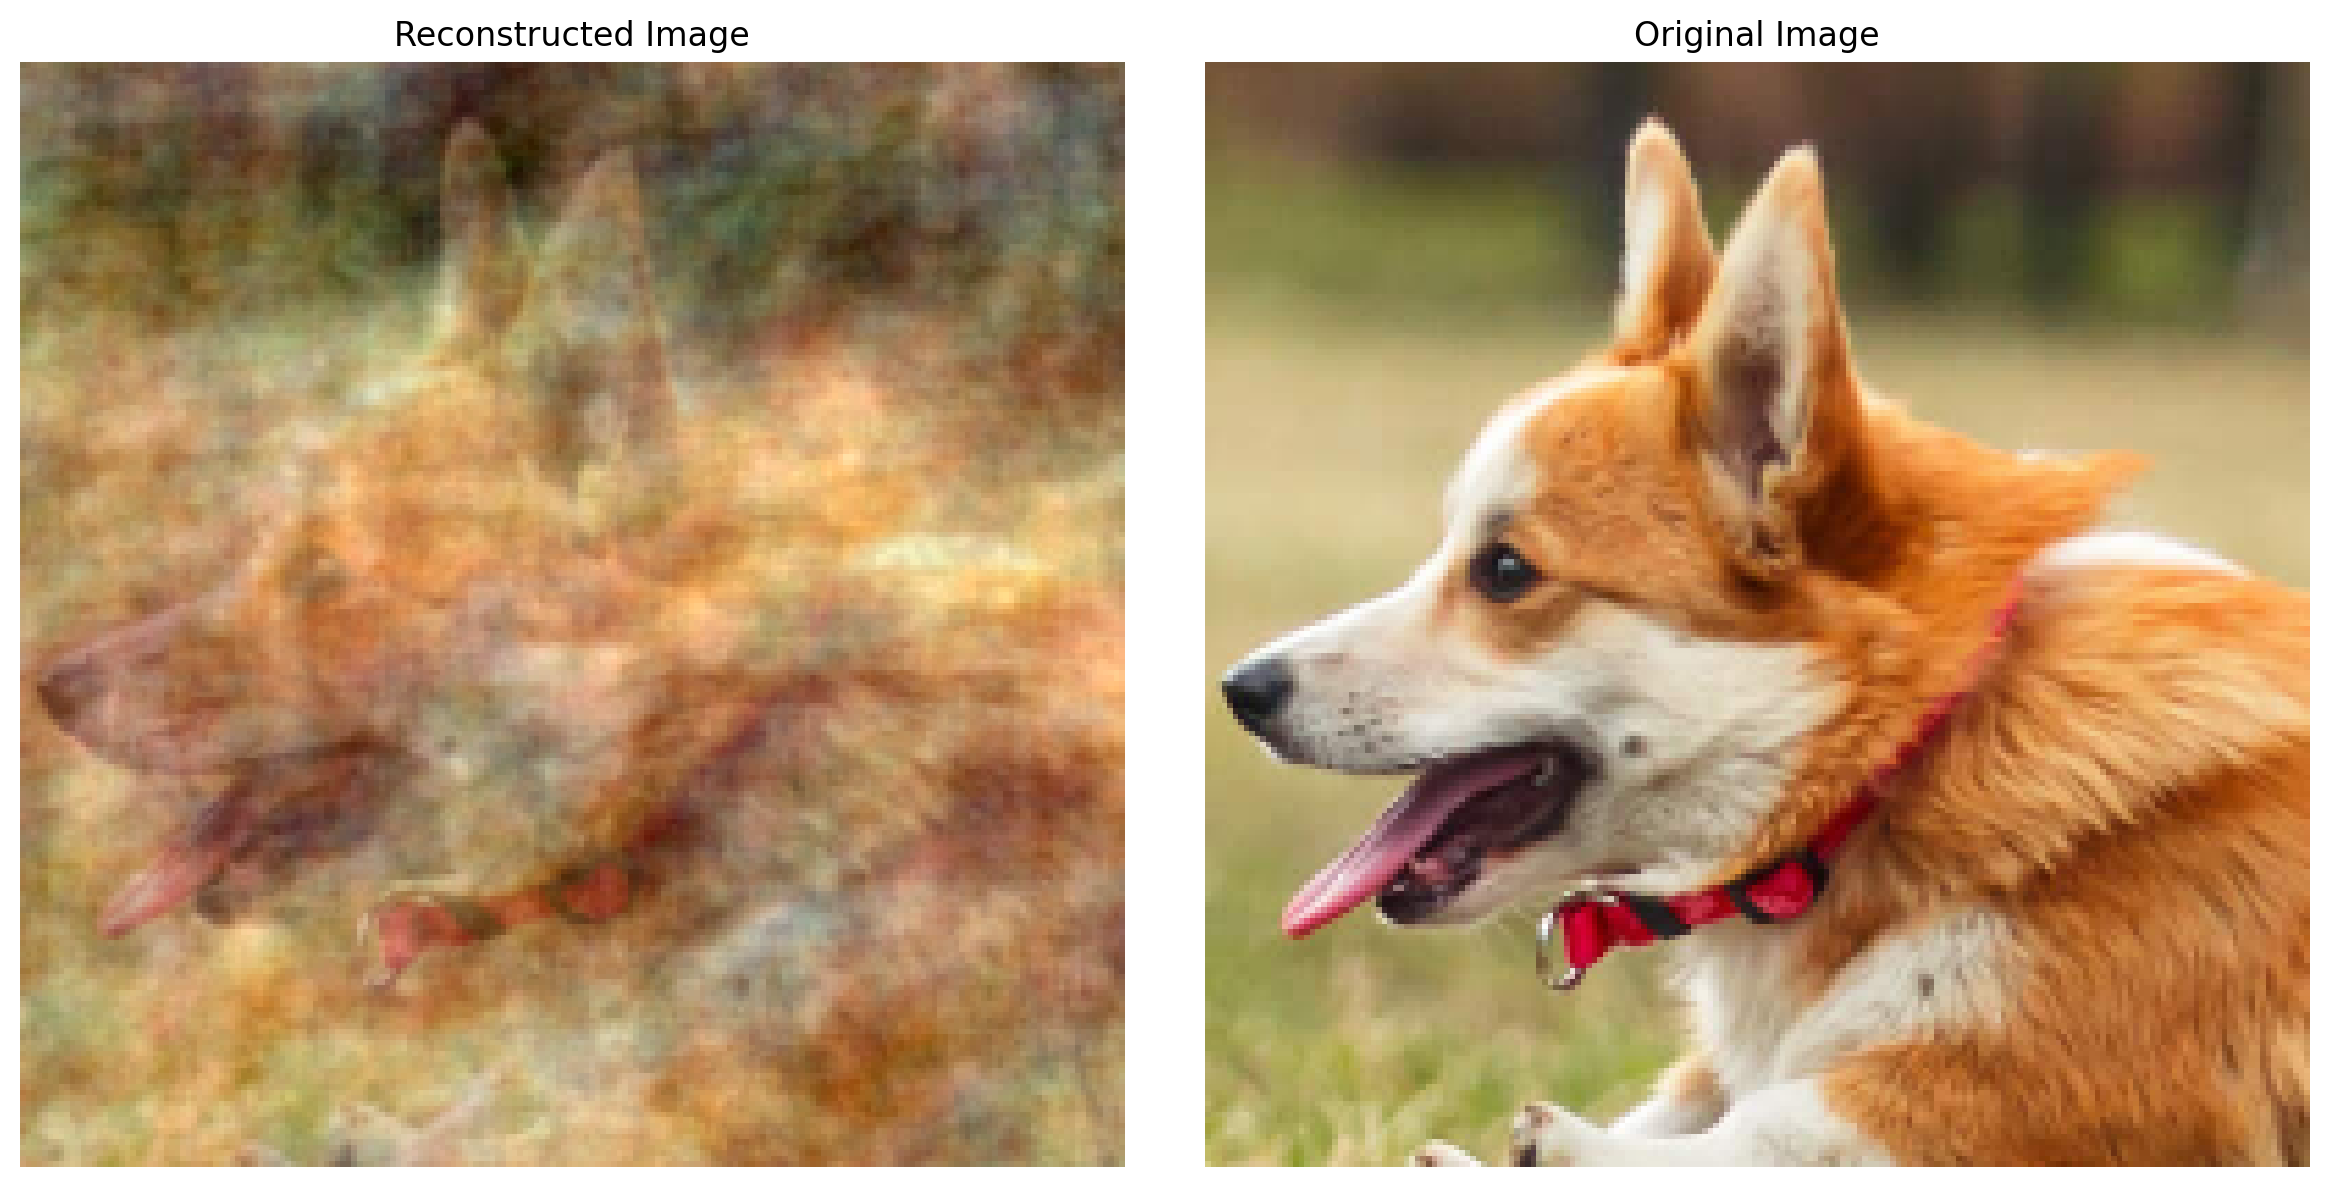

In [53]:
plot_reconstructed_and_original_image(resize_crop, model, X_200_rff)

In [54]:
from sklearn.metrics import mean_squared_error
import math


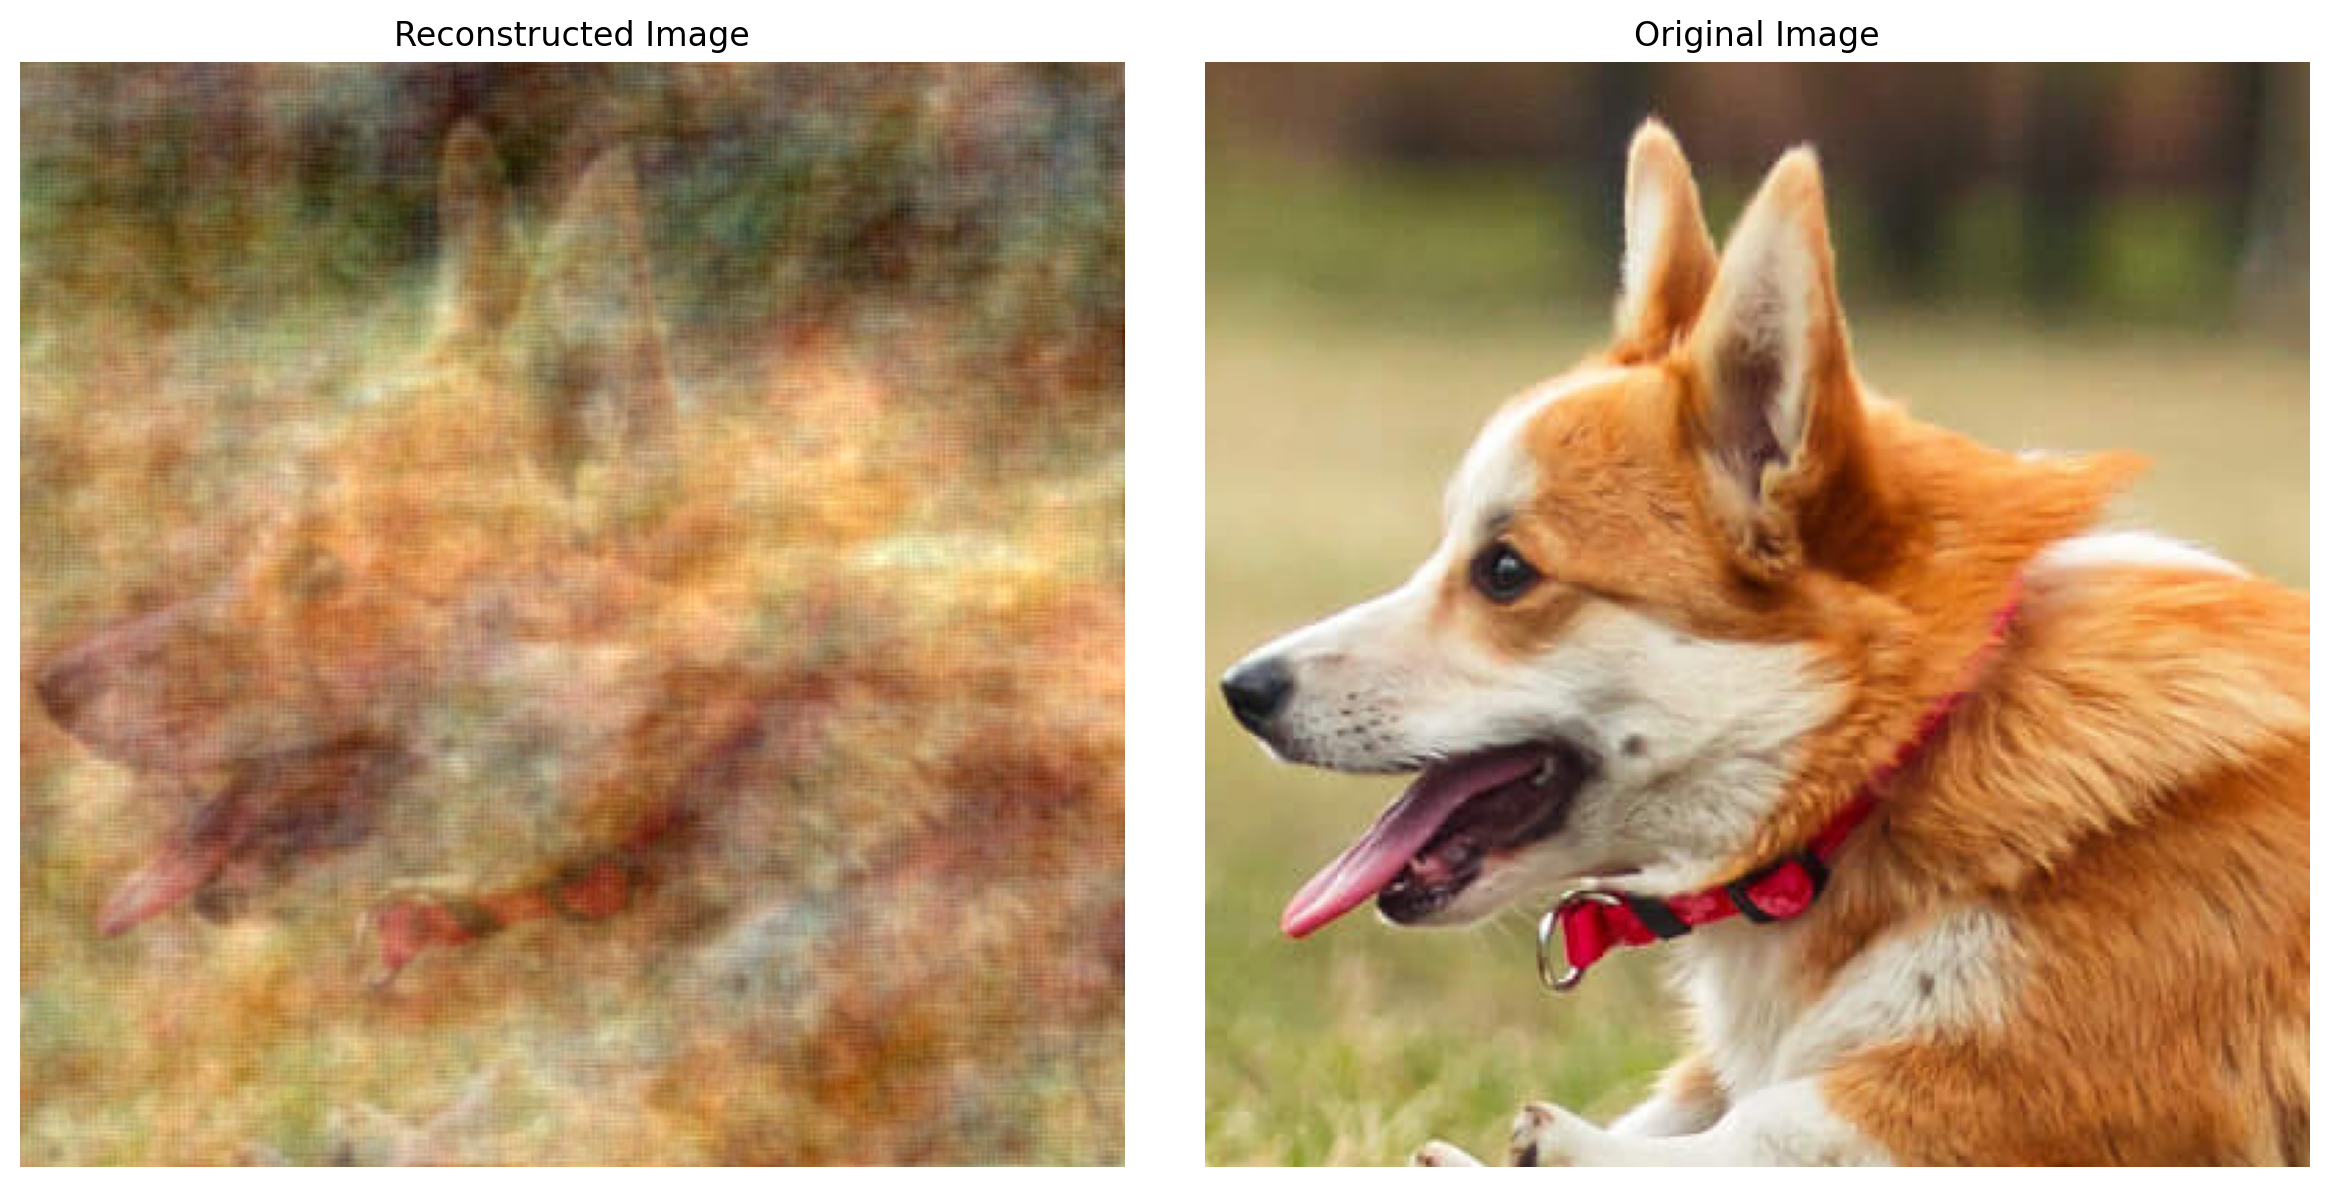

In [55]:


# Predict the pixel values for the 400x400 image
Y_pred_400 = model.predict(X_400_rff.cpu().numpy())

# Reshape predictions to (400, 400, num_channels)
Y_pred_400 = Y_pred_400.reshape(400, 400, 3)

# Convert the original image to numpy format for comparison
original_image_np = crop.cpu().permute(1, 2, 0).numpy()

# Plot the predicted 400x400 image vs original
plot_reconstructed_and_original_image(crop, model, X_400_rff)

In [56]:
# 1. Calculate RMSE
rmse = math.sqrt(mean_squared_error(original_image_np.flatten(), Y_pred_400.flatten()))
print(f"RMSE: {rmse}")

RMSE: 0.15468031109262192


In [57]:
# 2. Calculate PSNR
def calculate_psnr(original, predicted):
    mse = np.mean((original - predicted) ** 2)
    if mse == 0:  # If MSE is zero, the PSNR is infinite
        return float('inf')
    pixel_max = 1.0  # Assuming the images are normalized between 0 and 1
    psnr = 20 * math.log10(pixel_max / math.sqrt(mse))
    return psnr

psnr = calculate_psnr(original_image_np, Y_pred_400)
print(f"PSNR: {psnr} dB")

PSNR: 16.211299262924207 dB
